# MIE1624 Assignment 1 - Compensation Classification
##### Ziqi Zhang 1001374684

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [0]:
# import data
data = pd.read_csv("/content/drive/My Drive/Master/MIE1624/Kaggle_Salary.csv") 

# Step 1: Data Cleaning and Feature Engineering




Since the data is mostly categorical, encoding is required when fitting logistic regression model. Therefore, the following actions are performed in this step:  
1. **Remove all 'Other_Text' indicator columns.** Since the exact context of the other text that participants filled in is not available, only knowing the presence of other text could lead to bias.  
2. **Introduce a new feature 'country_income_ranking'.** The engineered feature 'country_income_ranking' is created by ranking the average yearly compensation of all the countries presented in the survey. The average yearly compensation of a country is calculated as:<br><br><center>$\frac{\sum_{1}^{total\ number\ of\ buckets}(number\ of\ people\ from\ the\ country\ in\ the\ bucket)*(bucket\ encoding)}{total\  number\ of\ participants\ from\ the\ country}$ </center><br> Since all compensations are converted to USD, it is reasonable to assume that the yearly compensations are related to the values of the currencies and the size of the data industries in different countries  
3. **Remove participants who answer less than 24 questions.** There are 34 questions in total. If a participant leaves more than 10 questions blank, the data obtained from that participant may not be representative, which could lead to bias.
4. **One-hot encoding categorical data.** One-hot encoding transforms categorical data to numerical data without introducing ordinal relationship.



In [0]:
# remove 'Other_text' indicator column
data.drop(list(data.filter(regex = 'TEXT')), axis = 1, inplace = True)

# add new feature 'country_income_ranking'
def add_ranking(row):
  for i in range(len(drunstack.index)):
    if row['Q3'] == drunstack.index[i]:
      return drunstack.iloc[i,-1]
data_rank = data.groupby(['Q3','Q10_Encoded']).size()
drunstack = data_rank.unstack(level=1, fill_value=0)
drunstack['weighted_income'] = drunstack.apply(lambda row: sum((row.index+1)*row)/sum(row) ,axis=1)
drunstack['rank'] = drunstack['weighted_income'].rank()
drunstack = drunstack.sort_values(by=['weighted_income'])
data.insert(len(data.columns)-2, "Country_ranking", "")
data['Country_ranking'] = data.apply(add_ranking, axis=1)


# remove participants who answer less than 24 questions
data1 = data.iloc[:,:-2]
data1 = data1.replace(np.nan, ' ', regex=True)
for i in range(1,35):
  title = 'Q' + str(i) + '_'
  flag = False
  for j in range(len(data1.columns)):
    if title in data1.columns[j]:
      while title in data1.columns[j+1]:
        data1.iloc[:,j] = data1.iloc[:,j].astype(str) + data1.iloc[:,j+1].astype(str)
        data1 = data1.drop(data1.columns[j+1], axis=1)
        flag = True
        if j+1 == len(data1.columns):
          break
    if flag == True:
      break
# index of participant to be removed due to too less answered questions (<24)
remove = []
for i in range(len(data1.index)):
  if data1.loc[i,:].str.isspace().sum() > 10:
    remove.append(i)
remove_index = data1.index.isin(remove)
# remove participants
data = data[~remove_index].reset_index(drop=True)


# create empty dataframe df to hold encoded data
df = pd.DataFrame(index=range(len(data.index)))
# encoding
for i in range(len(data.columns)-2):
  if data.iloc[:,i].dtype.name != 'object':     # if numerical, copy directly
    df = df.join(data.iloc[:,[i]])
  elif data.iloc[:,i].dtype.name == 'object':     # if categorical, encode
    # one-hot encoding
    df = df.join(pd.get_dummies(data.iloc[:,i], prefix=data.columns[i], drop_first=False))

df.head()

,Time from Start to Finish (seconds),Q1_18-21,Q1_22-24,Q1_25-29,Q1_30-34,Q1_35-39,Q1_40-44,Q1_45-49,Q1_50-54,Q1_55-59,Q1_60-69,Q1_70+,Q2_Female,Q2_Male,Q2_Prefer not to say,Q2_Prefer to self-describe,Q3_Algeria,Q3_Argentina,Q3_Australia,Q3_Austria,Q3_Bangladesh,Q3_Belarus,Q3_Belgium,Q3_Brazil,Q3_Canada,Q3_Chile,Q3_China,Q3_Colombia,Q3_Czech Republic,Q3_Denmark,Q3_Egypt,Q3_France,Q3_Germany,Q3_Greece,Q3_Hong Kong (S.A.R.),Q3_Hungary,Q3_India,Q3_Indonesia,"Q3_Iran, Islamic Republic of...",Q3_Ireland,...,Q31_Part_10_Google Cloud Pub/Sub,Q31_Part_11_None,Q31_Part_12_Other,Q32_Part_1_SAS,Q32_Part_2_Cloudera,Q32_Part_3_Azure Machine Learning Studio,Q32_Part_4_Google Cloud Machine Learning Engine,Q32_Part_5_Google Cloud Vision,Q32_Part_6_Google Cloud Speech-to-Text,Q32_Part_7_Google Cloud Natural Language,Q32_Part_8_RapidMiner,Q32_Part_9_Google Cloud Translation,Q32_Part_10_Amazon SageMaker,Q32_Part_11_None,Q32_Part_12_Other,Q33_Part_1_ Google AutoML,Q33_Part_2_ H20 Driverless AI,Q33_Part_3_ Databricks AutoML,Q33_Part_4_ DataRobot AutoML,Q33_Part_5_ Tpot,Q33_Part_6_ Auto-Keras,Q33_Part_7_ Auto-Sklearn,Q33_Part_8_ Auto_ml,Q33_Part_9_ Xcessiv,Q33_Part_10_ MLbox,Q33_Part_11_None,Q33_Part_12_Other,Q34_Part_1_MySQL,Q34_Part_2_PostgresSQL,Q34_Part_3_SQLite,Q34_Part_4_Microsoft SQL Server,Q34_Part_5_Oracle Database,Q34_Part_6_Microsoft Access,Q34_Part_7_AWS Relational Database Service,Q34_Part_8_AWS DynamoDB,Q34_Part_9_Azure SQL Database,Q34_Part_10_Google Cloud SQL,Q34_Part_11_None,Q34_Part_12_Other,Country_ranking
0,510,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42.0
1,391,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,57.0
2,392,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0
3,470,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,42.0
4,529,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,14.0


## Step 2: Data Visualization

In [0]:
data2 = pd.read_csv("/content/drive/My Drive/Master/MIE1624/Kaggle_Salary.csv")  

In [0]:
# gender vs compensation
sub_raw1 = data2.groupby(['Q2','Q10_buckets']).size()
# age vs compensation
sub_raw2 = data2.groupby(['Q1']).size()
# education vs compensation
sub_raw3 = data2.groupby(['Q4', 'Q10_Encoded']).size()
unstack_raw3 = sub_raw3.unstack(level=1, fill_value=0)
unstack_raw3['avg'] = unstack_raw3.apply(lambda row: sum((row.index+1)*row)/sum(row) ,axis=1)

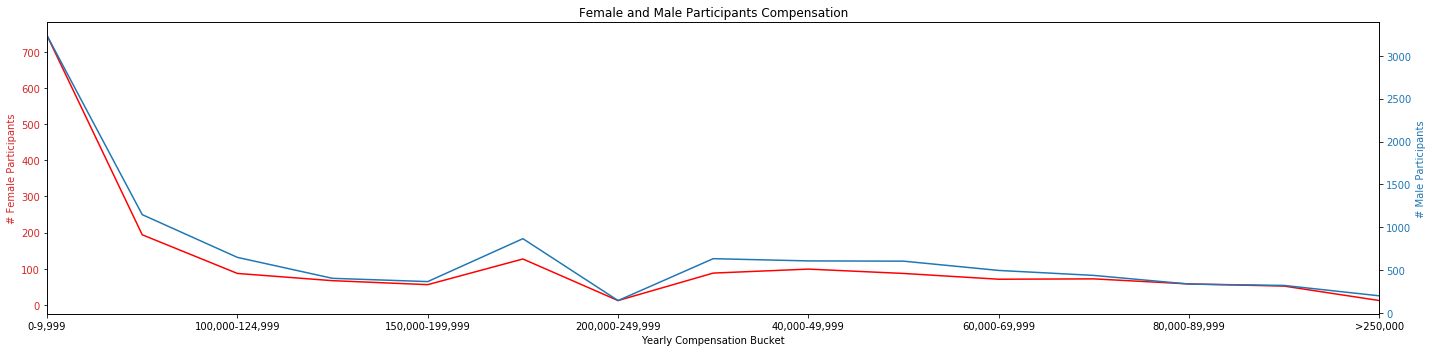

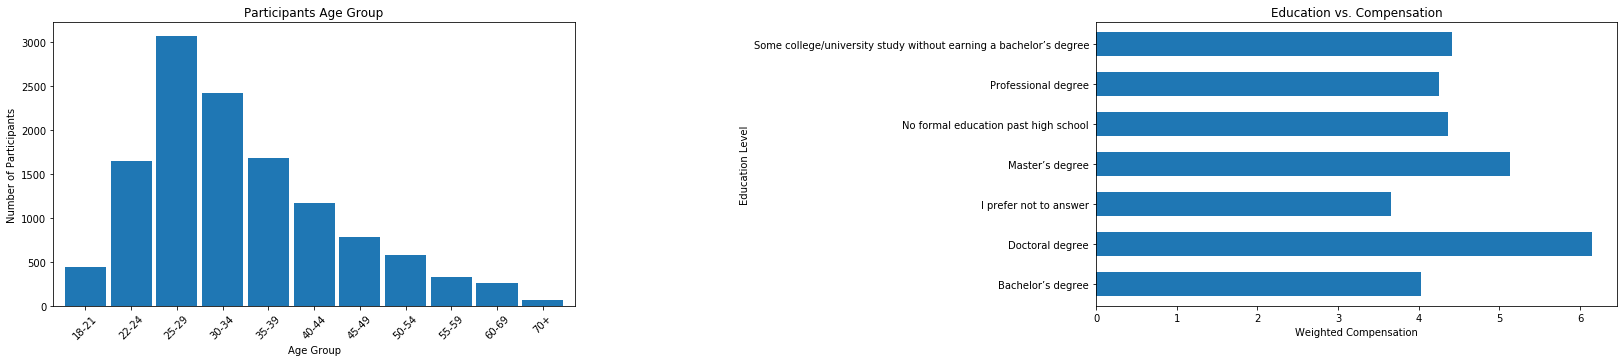

In [0]:
# Gender
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('# Female Participants', color=color)
sub_raw1['Female'].plot(kind='line', figsize=(20,5), color='red')
plt.title('Female and Male Participants Compensation')
plt.xlabel('Yearly Compensation Bucket')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('# Male Participants', color=color) 
sub_raw1['Male'].plot(kind='line', figsize=(20,5))
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout() 
plt.show()

# Age and Education
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.tight_layout(pad=2.0)
fig.set_size_inches(20,10)
plt.subplots_adjust(wspace = 1, right = 1.2)
# Age
plt.subplot(1, 2, 1)
sub_raw2.plot(width = 0.9, kind='bar', figsize=(20,15))
plt.xticks(rotation=45)
plt.title('Participants Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Participants')
# Education
plt.subplot(1, 2, 2)
unstack_raw3['avg'].plot(width = 0.6, kind='barh', figsize=(20,5))
plt.title('Education vs. Compensation')
plt.xlabel('Weighted Compensation')
plt.ylabel('Education Level')

plt.show()

From the above graphs, the following can be observed:  
1. The number or male participants is larger than the number of female participants. However, the compensation gap between male and female is small. Therefore, gender should not be significant to the prediction.  
2. Participants of age 22-44 are the majority of the survey. The prediction result should be most representative to such an age group.  
3. On average, Doctoral degree results in higher compensation, followed by Master's degree. Participants of other education level tend to have similar yearly compensation.

# Step 3: Feature Importance and Feauter Selection


For step 3, we first remove the features with small variances, since they potentially contribute less to the model. Since most of the features are binary after encoding, we remove features that over 95% of the participants gives the same answer.

In [0]:
# check if feature is biased and need to be removed
def is_bias(col):
  threshold = 0.05
  return col.value_counts().iloc[0] < len(df.index)*threshold or col.value_counts().iloc[0] > len(df.index)*(1-threshold)

df = df.drop(df.columns[df.apply(is_bias)], axis=1)
df['Q10_Encoded'] = data['Q10_Encoded']
df.head()

,Q1_22-24,Q1_25-29,Q1_30-34,Q1_35-39,Q1_40-44,Q1_45-49,Q2_Female,Q2_Male,Q3_India,Q3_Other,Q3_United States of America,Q4_Bachelor’s degree,Q4_Doctoral degree,Q4_Master’s degree,Q5_Data Analyst,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q6_0-49 employees,"Q6_1000-9,999 employees",Q6_250-999 employees,Q6_50-249 employees,"Q6_> 10,000 employees",Q7_0,Q7_1-2,Q7_10-14,Q7_20+,Q7_3-4,Q7_5-9,Q8_I do not know,Q8_No (we do not use ML methods),Q8_We are exploring ML methods (and may one day put a model into production),"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production),Q9_Part_1_Analyze and understand data to influence product or business decisions,"Q9_Part_2_Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Q9_Part_3_Build prototypes to explore applying machine learning to new areas,...,Q28_Part_6_ PyTorch,Q28_Part_7_ Caret,Q28_Part_8_ LightGBM,Q28_Part_9_ Spark MLib,Q28_Part_10_ Fast.ai,Q28_Part_11_None,Q29_Part_1_ Google Cloud Platform (GCP),Q29_Part_2_ Amazon Web Services (AWS),Q29_Part_3_ Microsoft Azure,Q29_Part_11_None,Q30_Part_1_AWS Elastic Compute Cloud (EC2),Q30_Part_2_Google Compute Engine (GCE),Q30_Part_3_AWS Lambda,Q30_Part_4_Azure Virtual Machines,Q30_Part_5_Google App Engine,Q30_Part_6_Google Cloud Functions,Q30_Part_8_Google Kubernetes Engine,Q30_Part_11_None,Q31_Part_1_Google BigQuery,Q31_Part_2_AWS Redshift,Q31_Part_3_Databricks,Q31_Part_7_Google Cloud Dataflow,Q31_Part_11_None,Q32_Part_3_Azure Machine Learning Studio,Q32_Part_4_Google Cloud Machine Learning Engine,Q32_Part_10_Amazon SageMaker,Q32_Part_11_None,Q33_Part_7_ Auto-Sklearn,Q33_Part_11_None,Q34_Part_1_MySQL,Q34_Part_2_PostgresSQL,Q34_Part_3_SQLite,Q34_Part_4_Microsoft SQL Server,Q34_Part_5_Oracle Database,Q34_Part_6_Microsoft Access,Q34_Part_7_AWS Relational Database Service,Q34_Part_10_Google Cloud SQL,Q34_Part_11_None,Country_ranking,Q10_Encoded
0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42.0,3
1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,57.0,14
2,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,42.0,6
4,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,14.0,1


221 features remaining after removing small variance features. Next, chi-square test is performed to check the correlation between each feature and the encoded compensation. Any feature with P-value < 0.05 is removed since their correlation with the target is too small.

In [0]:
def chi2test(col1,col2):
  sub_df = df.groupby([col1,col2]).size()
  unstack = sub_df.unstack(level=1, fill_value=0)
  stat, pval, dof, exp_table = chi2_contingency(unstack.values)
  return pval

# chi square test
p = []
for i in range(len(df.columns)-1):
  p.append(chi2test(df.columns[i], df.columns[-1]))

# sort p values
p_list = {'Feature': df.columns[0:-1], 'P-value': p}
df_p = pd.DataFrame(data=p_list)
df_p.sort_values(by=['P-value'], inplace=True, ascending=False)
df_p = df_p[df_p['P-value'] > 0.05]
features = df_p.index.tolist()
features.append(209)
features.append(210)
df = df.iloc[:,features].reset_index(drop=True)
df.head()

,Q20_Part_11_None,Q28_Part_4_ RandomForest,"Q26_Part_1_General purpose image/video tools (PIL, cv2, skimage, etc)",Q24_Part_7_Convolutional Neural Networks,Q22_2-5 times,Q13_Part_4_DataCamp,Q12_Part_12_Other,Q16_Part_6_ Visual Studio / Visual Studio Code,Q34_Part_3_SQLite,Q7_5-9,"Q12_Part_5_Course Forums (forums.fast.ai, etc)","Q14_Advanced statistical software (SPSS, SAS, etc.)",Q28_Part_11_None,Q7_10-14,Q34_Part_11_None,Q5_Research Scientist,"Q26_Part_2_Image segmentation methods (U-Net, Mask R-CNN, etc)",Q32_Part_3_Azure Machine Learning Studio,Q34_Part_6_Microsoft Access,Q28_Part_3_ Keras,"Q26_Part_4_Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)",Q28_Part_1_ Scikit-learn,Q34_Part_10_Google Cloud SQL,"Q16_Part_1_Jupyter (JupyterLab, Jupyter Notebooks, etc)",Q21_Part_1_CPUs,Q27_Part_5_None,"Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)",Q17_Part_7_ Binder / JupyterHub,Q18_Part_7_Javascript,Q17_Part_3_ Microsoft Azure Notebooks,"Q26_Part_3_Object detection methods (YOLOv3, RetinaNet, etc)",Q19_R,"Q24_Part_6_Dense Neural Networks (MLPs, etc)",Q28_Part_10_ Fast.ai,Q8_We use ML methods for generating insights (but do not put working models into production),Q21_Part_2_GPUs,Country_ranking,Q10_Encoded
0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,42.0,3
1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,57.0,14
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,14.0,0
3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,42.0,6
4,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,1,14.0,1


After the previous step, 37 featuers remains as listed above, in the order of most to least relavant to the compensation. From the list, we can observe that **Q20(visuallization tool), Q26(Computer vision method), Q28(Machine learning framework), Q34(relational database product)** are the most important features. The next step is to check the correlation between the remaining features to further eliminate features.

In [0]:
# check correlations between selected features
remove_feature = []
for i in range(len(df.columns)-2):
  for j in range(i+1,len(df.columns)-2):
    if chi2test(df.columns[i], df.columns[j]) > 0.5:
      remove_feature.append(df.columns[j])
remove_feature = list(set(remove_feature))
df1 = df.drop(remove_feature, axis=1)
df1.head()

,Q20_Part_11_None,Q28_Part_4_ RandomForest,"Q26_Part_1_General purpose image/video tools (PIL, cv2, skimage, etc)",Q24_Part_7_Convolutional Neural Networks,Q22_2-5 times,Q13_Part_4_DataCamp,Q34_Part_3_SQLite,"Q26_Part_2_Image segmentation methods (U-Net, Mask R-CNN, etc)","Q26_Part_4_Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)","Q26_Part_3_Object detection methods (YOLOv3, RetinaNet, etc)",Country_ranking,Q10_Encoded
0,0,0,0,0,0,1,0,0,0,0,42.0,3
1,0,1,1,1,0,1,0,0,1,0,57.0,14
2,0,1,0,0,0,0,0,0,0,0,14.0,0
3,0,1,0,1,0,0,0,0,0,0,42.0,6
4,0,0,1,1,0,0,0,1,0,1,14.0,1


In this step, if any two features have P-value greater than 0.5, the less important feature will be removed. As list above, 11 features remain, which will be used to train the model.

## Step 4: Logistic Regression


The entire dataset is randomly splited into 80% training data and 20% testing data. Three models with different hyper-parameters are trained. Details is reported at the end of this section.

In [0]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics, model_selection
np.random.seed(2222)

In [0]:
# prepare data
train = df1.iloc[:,:-1].to_numpy()
test = df1['Q10_Encoded'].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(train, test, test_size=0.2)

In [0]:
# start training, tuning hyper-parameters
model1 = LogisticRegressionCV(solver='lbfgs', multi_class='multinomial', penalty = 'l2', Cs=[0.1], cv=10, max_iter = 10000, verbose=10, n_jobs=-1).fit(X_train, y_train)
model2 = LogisticRegressionCV(solver='lbfgs', multi_class='multinomial', penalty = 'l2',Cs=[1], cv=10, max_iter = 10000, verbose=1, n_jobs=-1).fit(X_train, y_train)
model3 = LogisticRegressionCV(solver='saga', multi_class='multinomial', penalty = 'l1',Cs=[0.1], cv=10, max_iter = 10000, verbose=1, n_jobs=-1).fit(X_train, y_train)

In [0]:
# returns accuracy of each fold, avg and var of all folds
def folds_accuracy(model):
  fscore=[]
  for i in range(len(model.scores_[0])):
    sum_score = []
    for j in range(len(model.scores_)):
      sum_score.append(model.scores_[j][i])
    fscore.append(np.mean(sum_score))
  return fscore, np.mean(fscore), np.var(fscore)

In [0]:
# report results of each fold
models = [model1, model2, model3]
C = [0.1, 1, 0.1]
solver = ['lbfgs','lbfgs','saga']
penalty = ['l2','l2','l1']
for i in range(len(models)):
  print('Model {0} (C={1}, solver = {2}, penalty = {3}):'.format(i+1, C[i], solver[i], penalty[i]))
  print('Accuracy of each fold: ', folds_accuracy(models[i])[0])
  print('Mean accuracy: {0}'.format(folds_accuracy(models[i])[1]))
  print('Variance: {0}\n'.format(folds_accuracy(models[i])[2]))

Model 1 (C=0.1, solver = lbfgs, penalty = l2):
Accuracy of each fold:  [0.32538736591179973, 0.32538736591179973, 0.3134684147794993, 0.33134684147795, 0.3134684147794993, 0.32896305125148995, 0.31227651966626946, 0.3221957040572792, 0.33412887828162297, 0.3126491646778043]
Mean accuracy: 0.3219271720795014
Variance: 6.33451057146666e-05

Model 2 (C=1, solver = lbfgs, penalty = l2):
Accuracy of each fold:  [0.32538736591179973, 0.32777115613825986, 0.3146603098927293, 0.33492252681764, 0.3146603098927293, 0.32896305125148995, 0.31108462455303937, 0.3221957040572792, 0.33412887828162297, 0.3126491646778043]
Mean accuracy: 0.3226423091474394
Variance: 7.176042952281843e-05

Model 3 (C=0.1, solver = saga, penalty = l1):
Accuracy of each fold:  [0.32061978545887965, 0.3182359952324196, 0.3134684147794993, 0.32777115613825986, 0.3146603098927293, 0.3301549463647199, 0.31227651966626946, 0.3221957040572792, 0.3293556085918855, 0.31384248210023874]
Mean accuracy: 0.32025809222821805
Variance:

Among the three models, although their performance are similar, **model 2 (C=1, solver = lbfgs, penalty = l2)** performs the best.

## Step 5: Model Tuning


In this step, grid search method is applied to find the optimal hyper-parameters. The tunable variables are set to:  
**penalty** = ['l1','l2']  
**C** = [0.1,0.5,1,5,7,10]  
**solver** = ('newton-cg','lbfgs','saga','sag')  
Accuracy is set to be the scoring parameter of the grid search algorithm.
The grid search results are reported below.


In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
# grid search on hyper-parameters
parameters = {'penalty': ['l1','l2'], 'C':[0.1,0.5,1,5,7,10], 'solver':('newton-cg','lbfgs','saga','sag')}
lr = linear_model.LogisticRegression(multi_class='multinomial', max_iter = 1000)
gsearch = GridSearchCV(estimator = lr, param_grid = parameters, cv = 10, scoring = 'accuracy', n_jobs=-1, verbose = 1).fit(X_train, y_train)

In [0]:
print('Optimal hyper-parameter combination: {0}'.format(gsearch.best_params_))
print('Best train accuracy: {0}'.format(gsearch.best_score_))

Optimal hyper-parameter combination: {'C': 0.5, 'penalty': 'l1', 'solver': 'saga'}
Best train accuracy: 0.3263368995366116


In [0]:
# Apply optimal hyper-parameters on test set
optimal_test_score = gsearch.best_estimator_.score(X_test,y_test)
print('Best test set accuracy: {0}'.format(optimal_test_score))

Best test set accuracy: 0.31092036242250837


## Step 6: Testing and Disscussion

In this step, confusion matrix is plotted.

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
lr_model = linear_model.LogisticRegression(multi_class='multinomial', max_iter = 1000, C= 0.5, penalty= 'l1', solver= 'saga').fit(X_train,y_train)

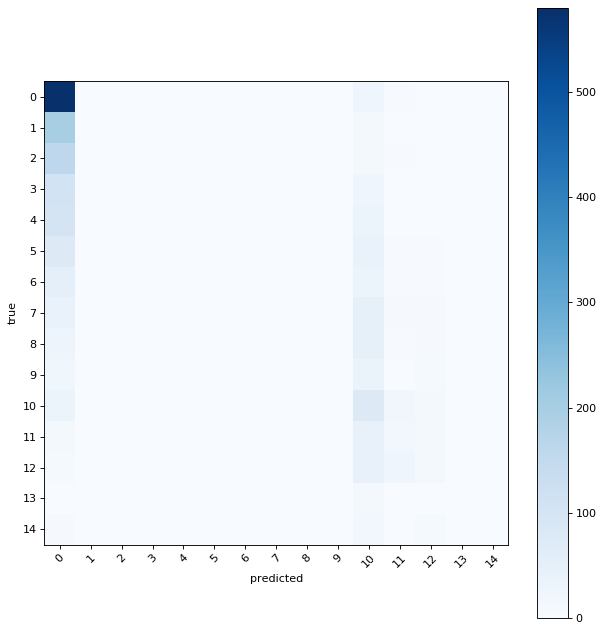

In [0]:
#compute confusion matrix
np.set_printoptions(precision=2)
cm = confusion_matrix(y_test,pred)

#set parameters for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plot elements
    plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim([14.5, -0.5])
    plt.xlabel('predicted')
    plt.ylabel('true')
            
    plt.tight_layout()
    
  
# Plot confusion matrix
plot_confusion_matrix(cm, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                      title='Confusion matrix')

From the confusion matrix, we can see that the most of the prediction results fall into class 0 and class 10.  
The overall prediction performance is not desirable, with accuracy = 0.3263 on training and accuracy = 0.3109 on testing set. Despite the bad performance, the accuracy on training and testing set is close, therefore, only a little bit overfitting.  
To improve the accuracy of training and testing, other model such as decision tree and random forest could be applied. Logistic regression is not particularly suirable for this type of dataset since most of the features are binary after encoding, which potentially results in bad regression performance. Although better feature engineering could possibly imporve the accuracy, but still not desirable.